This is a development notebook with the purpose of creating code that more efficiently generates black holes along various lines of sight in the Milky Way. Some of this is modified code from synthetic.py (commit d9dee2f).

In [1]:
import numpy as np
import astropy.coordinates as coord
from astropy import units
from scipy import interpolate, integrate
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Default inputs coped from function call
fdm=1
pbh_mass=40
r_max=8.3
c=12.94 # Concentration index.
r_vir=200
inner_slope=.5
v_esc=550
overwrite=False
seed=None

In [3]:
#Define parameters for NFW profile calculations
r_s = r_vir/c #kpc, scale radius
g = 4.3*(10**-3) #(pc*km^2)/(Msun*s^2)
h = 70 #km/(s*Mpc)

In [169]:
#Obtain survey area and center latitude and longitude
# b = float(ebf_log['latitude'])
# l = float(ebf_log['longitude'])
# surveyArea = float(ebf_log['surveyArea'])
# just hard coding some number for testing purposes
b = 1.25 * np.pi / 180 # rad
l = -2.64 * np.pi / 180 # rad
surveyArea = 0.001 # deg**2

In [170]:
#Calculate the size of the field of view we are running
field_of_view_radius = (surveyArea/np.pi)**(1/2) # deg
print('{0:0.5f} [deg]'.format(field_of_view_radius))

0.01784 [deg]


In [171]:
def rho_dmhalo(r, rho_0=0.0106, r_s=19, gamma=1):
    """
    Density profile of the dark matter halo.
    We are using the parametrization from McMillan (2017) Equation 5,
    with defaults based on the mean values in Table 2.
    r: galactocentric radius [units: kpc]
    rho_0: characteristic density in [units: m_sun / pc**3]
    r_s: scale radius in [units: kpc]
    gamma: gamma=1 for NFW, gamma > 1 cuspy, gamma < 1 cored
    
    returns: density at r [units: m_sun / pc**3]
    """
    x = r / r_s
    rho = rho_0 / (x**gamma * (1 + x)**(3 - gamma))
    return rho

In [172]:
# Maximum line of sight distance to consider for PBH injection
# heliocentric coordinate radius [units: kpc]
r_h_max = 16.6

In [173]:
# Generate an array of heliocentric radii
# These radii will just be used to numerically integrate the density
n_lin = 1000
if np.logical_and(np.logical_and(np.abs(l)<0.5 * np.pi / 180, 
                                 np.abs(b)<0.5 * np.pi / 180),
                  n_lin<100000):
    print('Warning: for fields very near the center of the Milky Way it is reocmmended that the number of elements used to estimate the density be n_lin>100000')
r_h_linspace = np.linspace(0, r_h_max, num=n_lin)

In [174]:
# Represent the line of sight line in galactic coordinates
galactic_lin = coord.Galactic(l=l * units.rad,
                              b=b * units.rad,
                              distance=r_h_linspace * units.kpc)

(0, 17.43)

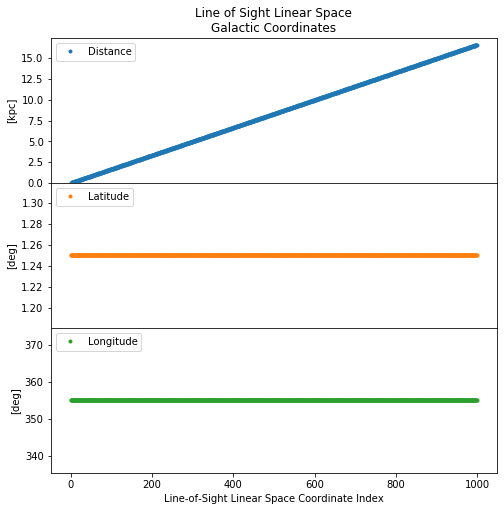

In [175]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0}, figsize=(8,8))
axs[0].plot(galactic_lin.distance.kpc, '.', label='Distance', c='C0')
axs[1].plot(galactic_lin.b.deg, '.', label='Latitude',c='C1')
axs[2].plot(galactic_lin.l.deg, '.', label='Longitude', c='C2')


plt.legend(loc='best')
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    ax.legend(loc='upper left')

axs[0].set_title('Line of Sight Linear Space\nGalactic Coordinates')
axs[0].set_ylabel('[kpc]')

axs[1].set_ylabel('[deg]')

axs[2].set_ylabel('[deg]')
axs[2].set_xlabel('Line-of-Sight Linear Space Coordinate Index')

axs[0].set_ylim(0, axs[0].set_ylim()[1])

In [176]:
# convert the line of sight to galactocentric coordinates
#outputs l, b, and distance in degrees.
galactocen_lin = galactic_lin.transform_to(coord.Galactocentric(representation_type='spherical'))


Create some diagnostic plots to make sure the coordinates are doing what we think they should.

(0, 8.747898173317495)

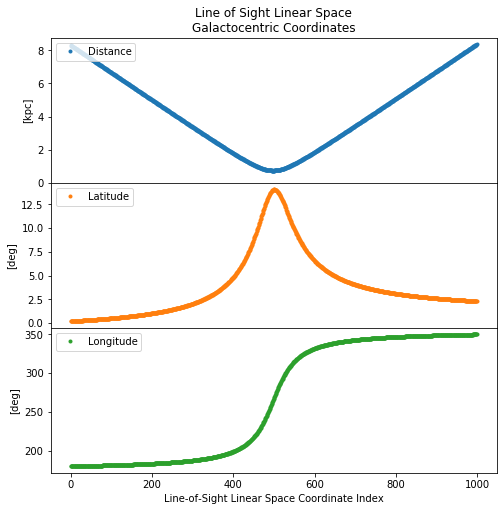

In [177]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0}, figsize=(8,8))
axs[0].plot(galactocen_lin.spherical.distance, '.', label='Distance', c='C0')
axs[1].plot(galactocen_lin.spherical.lat.deg, '.', label='Latitude', c='C1')
axs[2].plot(galactocen_lin.spherical.lon.deg, '.', label='Longitude',c='C2')

plt.legend(loc='best')
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    ax.legend(loc='upper left')

axs[0].set_title('Line of Sight Linear Space\nGalactocentric Coordinates')
axs[0].set_ylabel('[kpc]')

axs[1].set_ylabel('[deg]')

axs[2].set_ylabel('[deg]')
axs[2].set_xlabel('Line-of-Sight Linear Space Coordinate Index')

axs[0].set_ylim(0, axs[0].set_ylim()[1])

(0, 8.747898173317495)

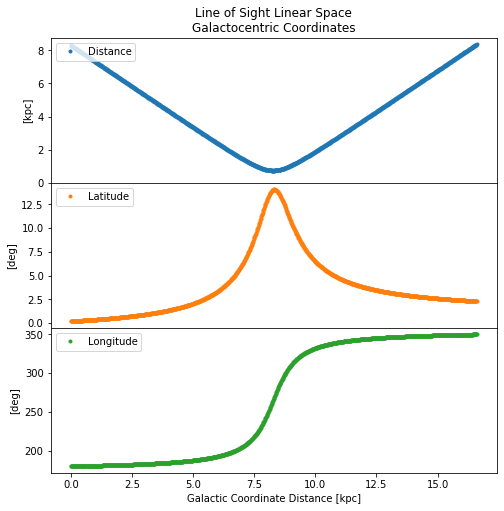

In [178]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0}, figsize=(8,8))
axs[0].plot(galactic_lin.distance.kpc,
            galactocen_lin.spherical.distance, '.', label='Distance', c='C0')
axs[1].plot(galactic_lin.distance.kpc,
            galactocen_lin.spherical.lat.deg, '.', label='Latitude', c='C1')
axs[2].plot(galactic_lin.distance.kpc,
            galactocen_lin.spherical.lon.deg, '.', label='Longitude',c='C2')

plt.legend(loc='best')
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    ax.legend(loc='upper left')

axs[0].set_title('Line of Sight Linear Space\nGalactocentric Coordinates')
axs[0].set_ylabel('[kpc]')

axs[1].set_ylabel('[deg]')

axs[2].set_ylabel('[deg]')
axs[2].set_xlabel('Galactic Coordinate Distance [kpc]')

axs[0].set_ylim(0, axs[0].set_ylim()[1])

Determine the dark matter density at all galactocentric radii along the line of sight.

In [125]:
# Determine the dark matter density at all galactocentric radii along the line of sight.
rho_lin = rho_dmhalo(galactocen_lin.spherical.distance.value,
                     rho_0=0.0106, r_s=19, gamma=1)
# Using Kerianne's original parameters
# Scale radius and rho_0 from Kerianne's original run
# rho_crit = ((3*(h**2))/(8*np.pi*g))*(10**6) #Msun/Mpc^3
# rho_knot = (200/3)*(rho_crit)*((c**3)/(np.log(c+1)-(c/(1+c)))) # Msun/Mpc^3
# print('r_s = {0} kpc'.format(r_s))
# print('rho_knot = {0} Msun/Mpc^3'.format(rho_knot))
# rho_lin = rho_dmhalo(galactocen_lin.spherical.distance.value,
#                      rho_0=rho_knot/(1e6)**3, r_s=r_s, gamma=1)

Text(0.5, 0.98, 'Milky Way Density along Line-of-Sight')

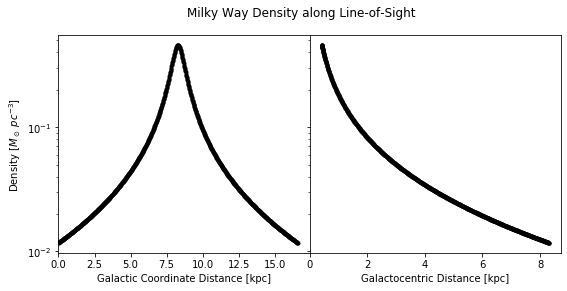

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4),
                               sharey=True, gridspec_kw={'wspace': 0})
# 
ax1.semilogy(galactic_lin.distance.kpc,
             rho_lin, '.',c='k')
ax1.set_ylabel('$\mathrm{Density}\ [M_\odot\ pc^{-3}]$')
ax1.set_xlabel('Galactic Coordinate Distance [kpc]')
ax1.set_xlim(0, ax1.set_xlim()[1])

ax2.semilogy(galactocen_lin.spherical.distance.value,
             rho_lin, '.',c='k')
ax2.set_xlabel('Galactocentric Distance [kpc]')
ax2.set_xlim(0, ax2.set_xlim()[1])

plt.suptitle('Milky Way Density along Line-of-Sight')



In [127]:
# Estimate the total mass within the line-of-sight cylinder [units: M_sun kpc**-2]
# Projected density along line of light
# (multiply by projected area to get total mass)
rho_marg_r = np.trapz(rho_lin, dx=r_h_max / n_lin) * 1000**3
print("Projected density along line-of-sight = {0:0.2e} [M_sun kpc**-2]".format(rho_marg_r))
# LOS cylinder radius in kpc, assuming small angle approximation [units: kpc]
r_proj_los_cyl = field_of_view_radius * np.pi / 180 * r_h_max
# Projected area of the LOS cylinder [units: kpc**2]
area_proj_los_cyl = np.pi * r_proj_los_cyl**2
# Mass within the total cylinder
mass_los_cyl = rho_marg_r * area_proj_los_cyl
print("Mass within line-of-sight cylinder = {0:0.2e} [M_sun]".format(mass_los_cyl))

Projected density along line-of-sight = 1.21e+09 [M_sun kpc**-2]
Mass within line-of-sight cylinder = 1.02e+05 [M_sun]


(0, 17.43)

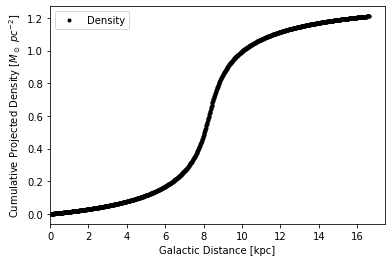

In [128]:
plt.plot(galactic_lin.distance.kpc,
         np.cumsum(rho_lin) * r_h_max / n_lin,
         '.', label='Density',c='k')
plt.legend(loc='best')
plt.ylabel('$\mathrm{Cumulative\ Projected\ Density}\ [M_\odot\ pc^{-2}]$')
plt.xlabel('Galactic Distance [kpc]')
plt.xlim(0, plt.xlim()[1])

In [129]:
# Total number of black holes to randomly draw
n_pbh = int(np.round(fdm * mass_los_cyl / pbh_mass))
print('Number of PBH to populate LOS cylinder with = {0}'.format(n_pbh))

Number of PBH to populate LOS cylinder with = 2539


In [130]:
# Estimate the discrete CDF based on the discrete PDF
# cdf_los = np.cumsum(rho_lin) / np.sum(rho_lin)
rho_marg_r_cum = integrate.cumtrapz(y=rho_lin,
                                          x=galactic_lin.distance.kpc,
                                          dx=r_h_max / n_lin)
cdf_los = rho_marg_r_cum / rho_marg_r_cum[-1]
# Since cumtrapz does not include zero for the first element insert it
cdf_los = np.insert(cdf_los,0,0)

In [131]:
# Verify correct size
print(np.size(cdf_los))
print(np.size(galactic_lin.distance.kpc))

1000
1000


Text(0.5, 0, 'Line-of-Sight Linear Space Coordinate Index')

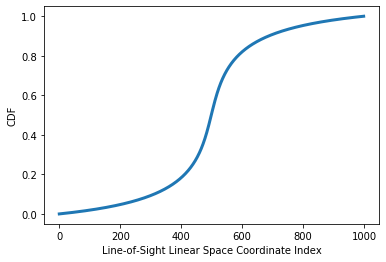

In [132]:
plt.plot(cdf_los, lw=3)
plt.ylabel('CDF')
plt.xlabel('Line-of-Sight Linear Space Coordinate Index')

In [133]:
# Create a function to interpolate the CDF so that we can randomly sample from it
f_cdf_d = interpolate.interp1d(cdf_los,
                               galactic_lin.distance.kpc)

Text(0.5, 0, 'Galactic Coordinate Distance along LOS [kpc]')

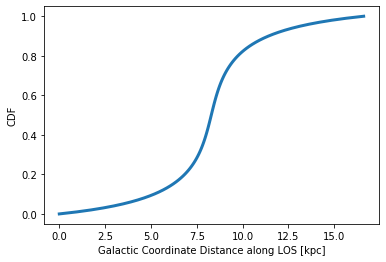

In [134]:
# Plot the interpolated CDF
x = np.linspace(0,1,100)
y = f_cdf_d(x)
plt.plot(y, x, lw=3)
plt.ylabel('CDF')
plt.xlabel('Galactic Coordinate Distance along LOS [kpc]')

In [135]:
# Randomly sample galactic coordinates for the PBHs based on CDF
d_galac = f_cdf_d(np.random.uniform(size=n_pbh))

In [136]:
# Randomly assign a l & b galactic coordinate to each PBH, within the LOS cone
# sample the angle from 0 to 2pi
theta = np.random.uniform(size=n_pbh) * 2 * np.pi
# sample radius correcting for annular area to make uniform
r_cyl = r_proj_los_cyl * np.sqrt(np.random.uniform(size=n_pbh)) # kpc
y_cyl = r_cyl * np.sin(theta) # kpc
x_cyl = r_cyl * np.cos(theta) # kpc

Text(0.5, 0.98, 'Distribution of PBHs in Cylindrical Line-of-Sight Tube (i.e. not light cone)')

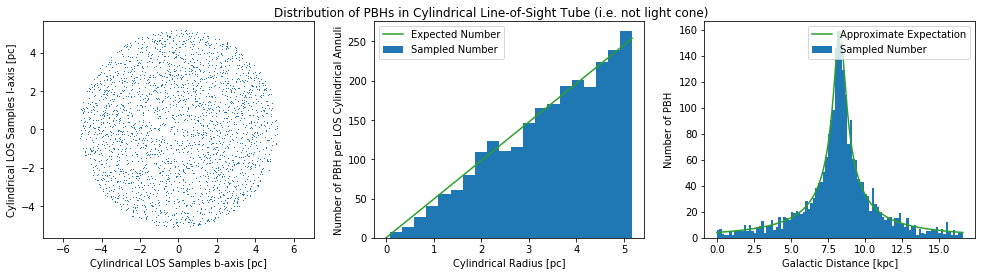

In [137]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))
# Create a plot to look at the projected cylindrical distribution of PBH
ax1.plot(x_cyl * 1000, y_cyl * 1000, ',')
ax1.set_aspect('equal', 'datalim')
ax1.set_ylabel('Cylindrical LOS Samples l-axis [pc]')
ax1.set_xlabel('Cylindrical LOS Samples b-axis [pc]')
# Create a histogram of the infered radii to make sure that it shows the expected linear trend
bins = 20
ax2.hist(r_cyl * 1000, bins=bins, label='Sampled Number')
ax2.plot((0, r_proj_los_cyl * 1000), (0, 2 * n_pbh / bins), c='C2', label='Expected Number')
ax2.legend(loc='upper left')
ax2.set_ylabel('Number of PBH per LOS Cylindrical Annuli')
ax2.set_xlabel('Cylindrical Radius [pc]')

# Create a histogram of the galactic distance distribution
bins=100
n_per_bin, _, _ = ax3.hist(d_galac, bins=bins, label='Sampled Number')
ax3.plot(galactic_lin.distance.kpc,
         rho_lin * area_proj_los_cyl / pbh_mass * r_h_max / bins * 1000**3,c='C2', label='Approximate Expectation')
ax3.legend(loc='best')
ax3.set_ylabel('Number of PBH')
ax3.set_xlabel('Galactic Distance [kpc]')

fig.tight_layout(pad=2.0)

plt.suptitle('Distribution of PBHs in Cylindrical Line-of-Sight Tube (i.e. not light cone)')

In [138]:
# Mask out sampled PBH outside the observation cone
mask = r_cyl <= r_proj_los_cyl * d_galac / r_h_max

In [139]:
print('Number of PBH before and after light cone masking: {0} and {1}, respectively'.format(n_pbh, np.sum(mask)))

Number of PBH before and after light cone masking: 2539 and 672, respectively


In [140]:
# Assuming small angle approximation
b_galac = r_cyl * np.sin(theta) / d_galac + b # rad
l_galac = r_cyl * np.cos(theta) / np.cos(b) / d_galac + l # rad

Text(0.5, 0, 'Galactic Coordinate Distance [kpc]')

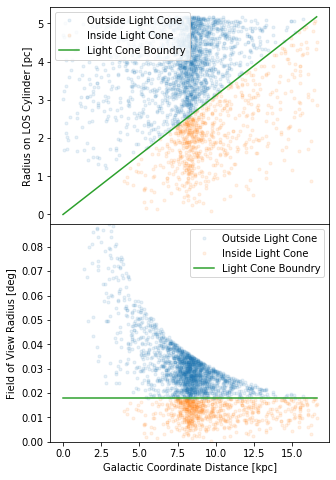

In [141]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,8),
                               sharex=True, gridspec_kw={'hspace': 0})
ax1.plot(d_galac[~mask], r_cyl[~mask] * 1000,
         '.', alpha=0.1, label='Outside Light Cone')
ax1.plot(d_galac[mask], r_cyl[mask] * 1000,
         '.', alpha=0.1, label='Inside Light Cone')
ax1.plot((0,r_h_max),
         (0, field_of_view_radius * np.pi / 180 * r_h_max *1000),
         label='Light Cone Boundry')
ax1.legend(loc='upper left')
ax1.set_ylabel('Radius on LOS Cylinder [pc]')

ax2.plot(d_galac[~mask], np.sqrt((l_galac[~mask] - l)**2 + 
                                 (b_galac[~mask] - b)**2) * 180/np.pi,
         '.', alpha=0.1, label='Outside Light Cone' )
ax2.plot(d_galac[mask], np.sqrt((l_galac[mask] - l)**2 +
                                (b_galac[mask] - b)**2) * 180/np.pi,
         '.', alpha=0.1, label='Inside Light Cone')
ax2.plot((0,r_h_max),
         (field_of_view_radius, field_of_view_radius), label='Light Cone Boundry')
ax2.set_ylim(0,5*field_of_view_radius)
ax2.legend(loc='best')
ax2.set_ylabel('Field of View Radius [deg]')
ax2.set_xlabel('Galactic Coordinate Distance [kpc]')


Given all of this we should now have the appropriate number of black holes in our light cone, and their galactic coordinates: `l_galac`, `b_galac`, `d_galac`